In [67]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite, community
import math
from collections import Counter
import numpy as np

DATA_DIR = '../../data/'
YEAR = 2025

stock_tx = pd.read_csv(f'{DATA_DIR}cleaned/2021-2023/stocks.csv')
stock_tx = stock_tx[stock_tx['year'] == YEAR]
print(stock_tx["type"].unique())
print(stock_tx["amount"].unique())
stock_tx.head()



[]
[]


,transaction_date,ticker,asset_description,type,amount,state,ptr_link,industry,sector,party,chamber,member,year,last_name,member_id


In [68]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite, community
from itertools import combinations
from datetime import datetime

# --- CONFIG ---
DATA_DIR = '../../data/cleaned/2021-2023'
YEAR     = 2023
CSV_PATH = f'{DATA_DIR}/stocks.csv'

# --- 1) LOAD & FILTER ---
stock_tx = pd.read_csv(CSV_PATH, parse_dates=['transaction_date'])
stock_tx = stock_tx[stock_tx['year'] == YEAR]

# --- 2) CLEAN UP TRANSACTION TYPES ---
stock_tx['type_clean'] = (
    stock_tx['type']
      .str.lower()
      .str.replace(r'[\s\(\)]', '_', regex=True)
      .replace({
          'sale__full':    'sale',
          'sale__partial': 'sale',
          'sale_full':     'sale',
          'sale_partial':  'sale',
          'purchase':      'purchase',
          'exchange':      'exchange'
      })
)

# --- 3) COMPUTE DOLLAR SUMS & COUNTS PER ROW ---
stock_tx['sale_amount']     = np.where(stock_tx['type_clean']=='sale',     stock_tx['amount'], 0)
stock_tx['purchase_amount'] = np.where(stock_tx['type_clean']=='purchase', stock_tx['amount'], 0)
stock_tx['num_sells']       = (stock_tx['type_clean']=='sale').astype(int)
stock_tx['num_buys']        = (stock_tx['type_clean']=='purchase').astype(int)

# --- 4) AGGREGATE PER MEMBER & TICKER ---
profit_df = (
    stock_tx
    .groupby(['member_id','member','ticker'], as_index=False)
    .agg(
        sum_purchases=('purchase_amount','sum'),
        sum_sales    =('sale_amount',    'sum'),
        num_buys      =('num_buys',       'sum'),
        num_sells     =('num_sells',      'sum')
    )
)
profit_df['profit'] = profit_df['sum_sales'] - profit_df['sum_purchases']

# --- 5) BUILD BIPARTITE GRAPH ---
B = nx.Graph()
members = profit_df['member_id'].unique().tolist()
tickers = profit_df['ticker'].unique().tolist()
B.add_nodes_from(members, bipartite='members')
B.add_nodes_from(tickers, bipartite='tickers')

for _, row in profit_df.iterrows():
    B.add_edge(
        row['member_id'],
        row['ticker'],
        profit      = row['profit'],
        purchases   = row['sum_purchases'],
        sales       = row['sum_sales'],
        trades_buys = row['num_buys'],
        trades_sells=row['num_sells']
    )

# --- 6) PROJECT TO MEMBER–MEMBER GRAPH (profit-weighted) ---
M = nx.Graph()
M.add_nodes_from(members)

for ticker in tickers:
    traders = [n for n in B.neighbors(ticker) if B.nodes[n]['bipartite']=='members']
    for u, v in combinations(traders, 2):
        # weight = sum of both members' profit on this ticker
        w = B.edges[u, ticker]['profit'] + B.edges[v, ticker]['profit']
        if M.has_edge(u, v):
            M[u][v]['weight'] += w
        else:
            M.add_edge(u, v, weight=w)

# --- 7) COMMUNITY DETECTION ON MEMBER GRAPH ---
communities = community.greedy_modularity_communities(M, weight='weight')
for i, comm in enumerate(communities, 1):
    print(f'Community {i} ({len(comm)} members): {list(comm)[:5]} ...')

# --- 8) CENTRALITY MEASURES ---
deg_cent = nx.degree_centrality(M)
bet_cent = nx.betweenness_centrality(M, weight='weight', normalized=True)
top_brokers = sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print('\nTop 10 "brokers" by betweenness centrality:')
for member_id, score in top_brokers:
    print(f'  {member_id}: {score:.4f}')

# --- 9) OUTLIER PROFIT DETECTION ---
threshold = profit_df['profit'].quantile(0.99)
outliers = profit_df[profit_df['profit'] > threshold].sort_values('profit', ascending=False)
print(f'\nProfit outliers (above 99th percentile ≈ ${threshold:,.0f}):')
print(outliers[['member_id','ticker','profit']].head(10))

# --- 10) TIME-SLICED ANALYSIS (BY QUARTER) ---
stock_tx['quarter'] = stock_tx['transaction_date'].dt.to_period('Q')
for q, df_q in stock_tx.groupby('quarter'):
    tmp = (
        df_q
        .groupby(['member_id','ticker'])
        .agg(buys=('purchase_amount','sum'),
             sells=('sale_amount','sum'))
        .reset_index()
    )
    tmp['profit'] = tmp['sells'] - tmp['buys']
    print(f'\n=== {q} ===')
    print(tmp.sort_values('profit', ascending=False).head(3))

# --- 11) OPTIONAL: TICKER–TICKER PROJECTION ---
T = bipartite.weighted_projected_graph(B, tickers)
ticker_comms = community.greedy_modularity_communities(T, weight='weight')
print(f'\nFound {len(ticker_comms)} ticker communities.')


Community 1 (17 members): ['E000296', 'M001205', 'S372', 'S386', 'M001220'] ...
Community 2 (7 members): ['B001316', 'T000483', 'C001114', 'K000375', 'S408'] ...
Community 3 (4 members): ['D000399', 'K000398', 'M001217', 'G000591'] ...
Community 4 (3 members): ['D000624', 'T000488', 'F000459'] ...
Community 5 (2 members): ['G000590', 'S000168'] ...
Community 6 (1 members): ['C001053'] ...
Community 7 (1 members): ['C001078'] ...
Community 8 (1 members): ['C001103'] ...
Community 9 (1 members): ['C001120'] ...
Community 10 (1 members): ['D000628'] ...
Community 11 (1 members): ['J000308'] ...
Community 12 (1 members): ['K000376'] ...
Community 13 (1 members): ['K000392'] ...
Community 14 (1 members): ['L000564'] ...
Community 15 (1 members): ['L000566'] ...
Community 16 (1 members): ['L000590'] ...
Community 17 (1 members): ['M000317'] ...
Community 18 (1 members): ['M001204'] ...
Community 19 (1 members): ['M001222'] ...
Community 20 (1 members): ['P000197'] ...
Community 21 (1 members

/var/folders/jx/7k6544kn35n00wd0kcwf51300000gn/T/ipykernel_1746/3438231104.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_comms)
/Users/luisbravo/Desktop/CongressTradeNet/venv/lib/python3.13/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


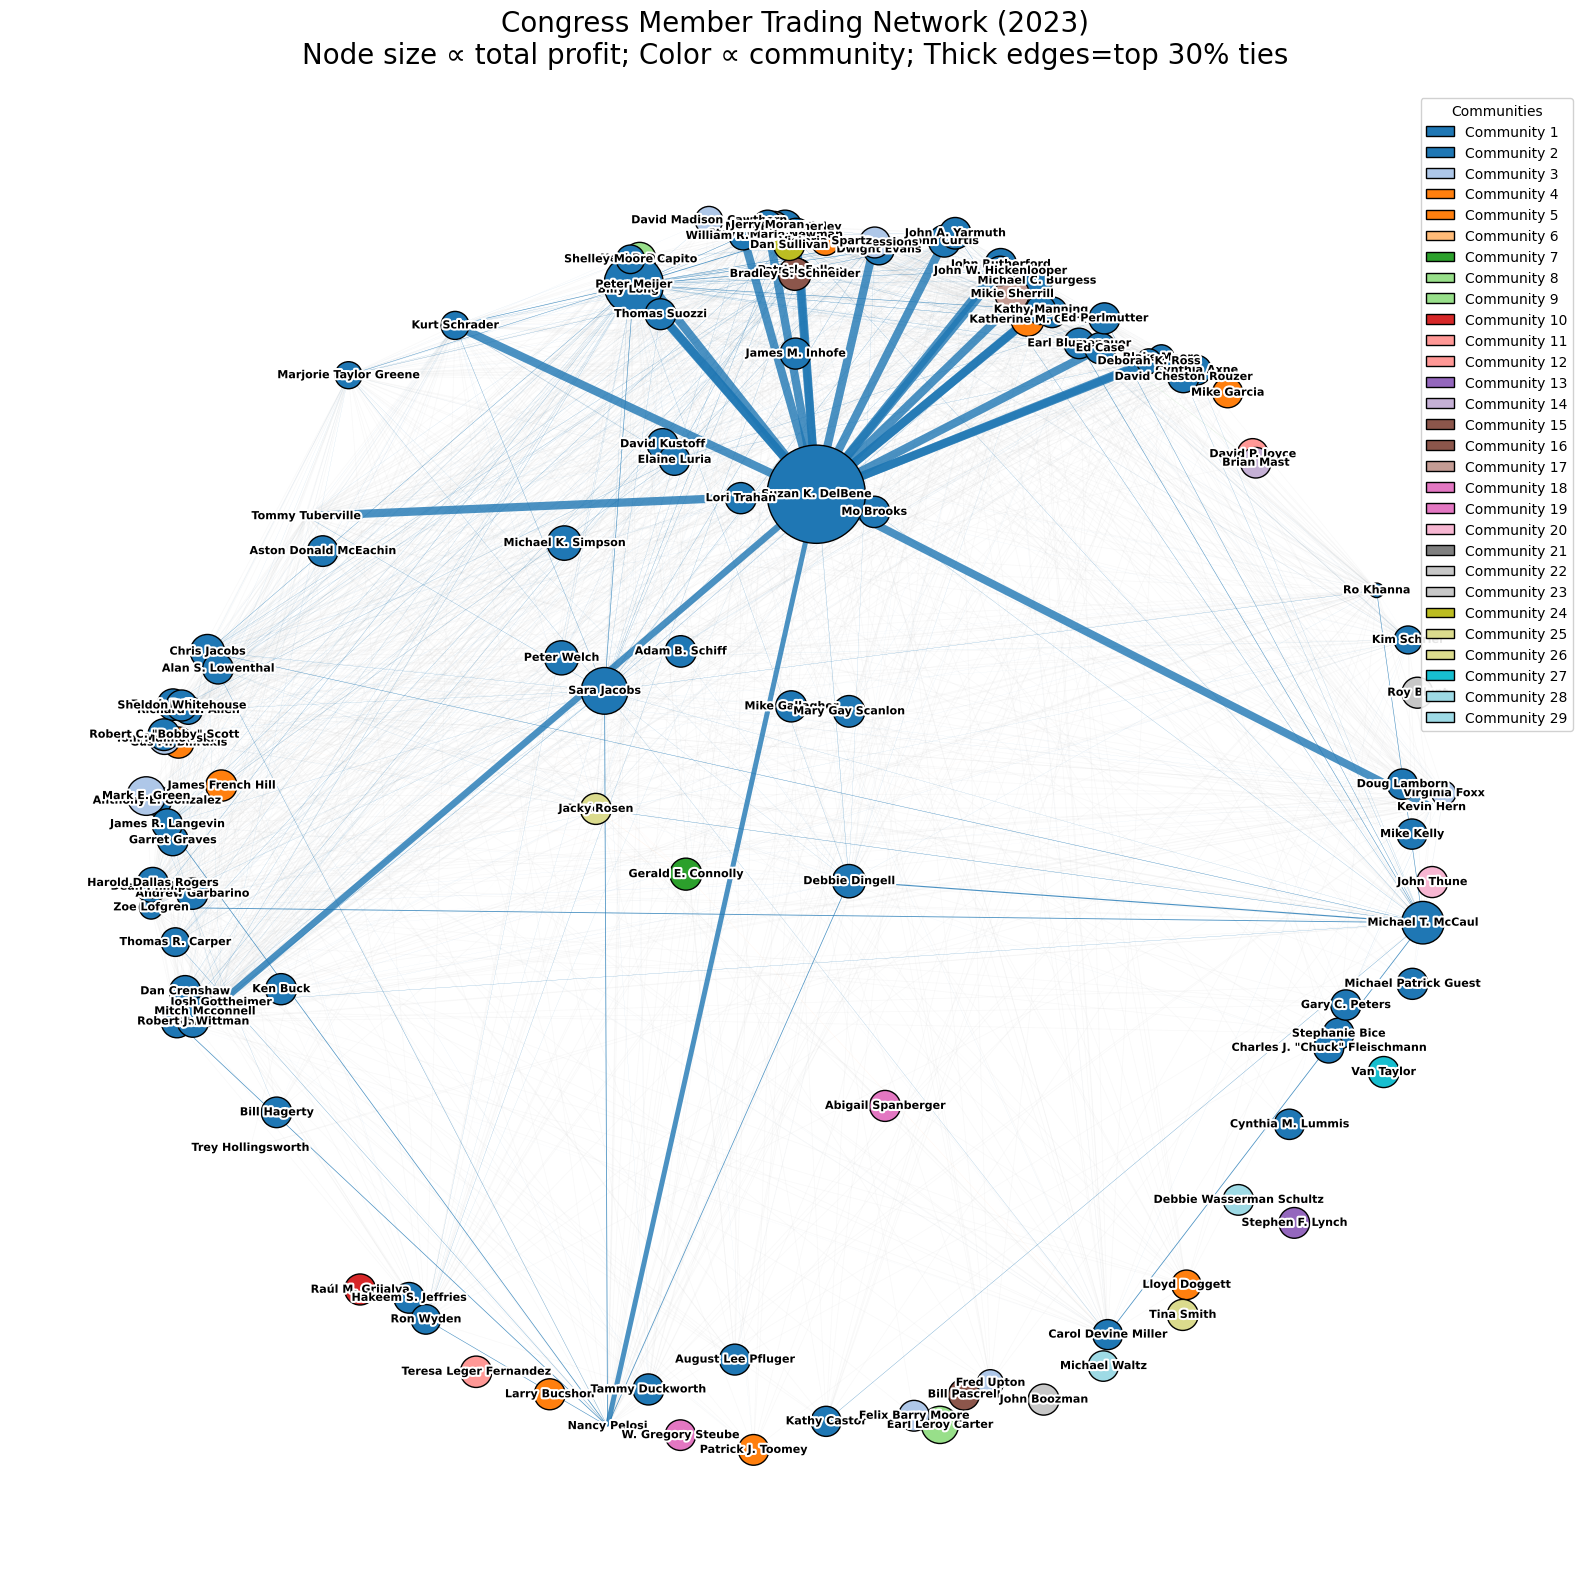

In [72]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite, community
from itertools import combinations
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import patheffects
from matplotlib.patches import Patch

# --- CONFIG ---
DATA_DIR = '../../data/cleaned/2021-2023'
YEAR     = 2021
CSV_PATH = f'{DATA_DIR}/stocks.csv'

# --- 1) LOAD & FILTER ---
stock_tx = pd.read_csv(CSV_PATH, parse_dates=['transaction_date'])
stock_tx = stock_tx[stock_tx['year'] == YEAR]

# --- 2) CLEAN UP TRANSACTION TYPES ---
stock_tx['type_clean'] = (
    stock_tx['type']
      .str.lower()
      .str.replace(r'[\s\(\)]', '_', regex=True)
      .replace({
          'sale__full':    'sale',
          'sale__partial': 'sale',
          'sale_full':     'sale',
          'sale_partial':  'sale',
          'purchase':      'purchase',
          'exchange':      'exchange'
      })
)

# --- 3) COMPUTE DOLLAR SUMS & COUNTS PER ROW ---
stock_tx['sale_amount']     = np.where(stock_tx['type_clean']=='sale',     stock_tx['amount'], 0)
stock_tx['purchase_amount'] = np.where(stock_tx['type_clean']=='purchase', stock_tx['amount'], 0)
stock_tx['num_sells']       = (stock_tx['type_clean']=='sale').astype(int)
stock_tx['num_buys']        = (stock_tx['type_clean']=='purchase').astype(int)

# --- 4) AGGREGATE PER MEMBER & TICKER ---
profit_df = (
    stock_tx
    .groupby(['member_id','member','ticker'], as_index=False)
    .agg(
        sum_purchases=('purchase_amount','sum'),
        sum_sales    =('sale_amount',    'sum'),
        num_buys      =('num_buys',       'sum'),
        num_sells     =('num_sells',      'sum')
    )
)
profit_df['profit'] = profit_df['sum_sales'] - profit_df['sum_purchases']

# build ID→name map for later labeling
id_to_name = dict(zip(profit_df['member_id'], profit_df['member']))

# --- 5) BUILD BIPARTITE GRAPH ---
B = nx.Graph()
members = profit_df['member_id'].unique().tolist()
tickers = profit_df['ticker'].unique().tolist()
B.add_nodes_from(members, bipartite='members')
B.add_nodes_from(tickers, bipartite='tickers')

for _, row in profit_df.iterrows():
    B.add_edge(
        row['member_id'],
        row['ticker'],
        profit      = row['profit'],
        purchases   = row['sum_purchases'],
        sales       = row['sum_sales'],
        trades_buys = row['num_buys'],
        trades_sells=row['num_sells']
    )

# --- 6) PROJECT TO MEMBER–MEMBER GRAPH (profit-weighted) ---
M = nx.Graph()
M.add_nodes_from(members)

for ticker in tickers:
    traders = [n for n in B.neighbors(ticker) if B.nodes[n]['bipartite']=='members']
    for u, v in combinations(traders, 2):
        w = B.edges[u, ticker]['profit'] + B.edges[v, ticker]['profit']
        if M.has_edge(u, v):
            M[u][v]['weight'] += w
        else:
            M.add_edge(u, v, weight=w)

# --- 7) COMMUNITY DETECTION ON MEMBER GRAPH ---
comms = list(community.greedy_modularity_communities(M, weight='weight'))
node_comm = {n: i for i, comm in enumerate(comms) for n in comm}
num_comms = len(comms)

# --- 8) PLOTTING ---
# prepare colormap and legend handles
cmap = plt.cm.get_cmap('tab20', num_comms)
legend_handles = [
    Patch(facecolor=cmap(i), edgecolor='k', label=f"Community {i+1}")
    for i in range(num_comms)
]

# compute raw profits & scale node sizes to 500–5000
raw = np.array([profit_df.loc[profit_df.member_id==n, 'profit'].sum() 
                for n in M.nodes()], dtype=float)
if raw.max()>0:
    sizes = 500 + (raw/raw.max())*(5000-500)
else:
    sizes = np.full_like(raw, 500)

# split edges into weak (bottom 70%) and strong (top 30%)
weights = np.array([d['weight'] for *_, d in M.edges(data=True)])
thr = np.quantile(weights, 0.7)
weak = [(u,v) for u,v,d in M.edges(data=True) if d['weight'] < thr]
strong = [(u,v) for u,v,d in M.edges(data=True) if d['weight'] >= thr]

# layout with tighter clustering
pos = nx.spring_layout(M, k=0.08, iterations=200, seed=42)

fig, ax = plt.subplots(figsize=(16,16))
ax.set_facecolor('white')

# draw weak ties
nx.draw_networkx_edges(M, pos,
    edgelist=weak,
    alpha=0.15,
    width=0.5,
    edge_color='lightgray',
    ax=ax
)

# draw strong ties colored by community midpoint
ec = [cmap((node_comm[u]+node_comm[v])//2) for u,v in strong]
ew = [M[u][v]['weight']/weights.max()*6 for u,v in strong]
nx.draw_networkx_edges(M, pos,
    edgelist=strong,
    width=ew,
    edge_color=ec,
    alpha=0.8,
    ax=ax
)

# draw nodes with black outlines
nc = [cmap(node_comm[n]) for n in M.nodes()]
nx.draw_networkx_nodes(M, pos,
    node_color=nc,
    node_size=sizes,
    edgecolors='k',
    linewidths=1,
    ax=ax
)

# label every node with a white halo
for n in M.nodes():
    x,y = pos[n]
    txt = ax.text(x, y, id_to_name[n],
                  fontsize=8, fontweight='bold',
                  ha='center', va='center')
    txt.set_path_effects([
        patheffects.Stroke(linewidth=3, foreground='white'),
        patheffects.Normal()
    ])

# add community legend
ax.legend(handles=legend_handles,
          loc='upper right',
          title='Communities',
          frameon=True,
          framealpha=0.9)

ax.set_title(
    "Congress Member Trading Network (2023)\n"
    "Node size ∝ total profit; Color ∝ community; Thick edges=top 30% ties",
    fontsize=20,
    pad=20
)
ax.axis('off')
plt.tight_layout()
plt.show()


/var/folders/jx/7k6544kn35n00wd0kcwf51300000gn/T/ipykernel_1746/2498848803.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_comms)
/Users/luisbravo/Desktop/CongressTradeNet/venv/lib/python3.13/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


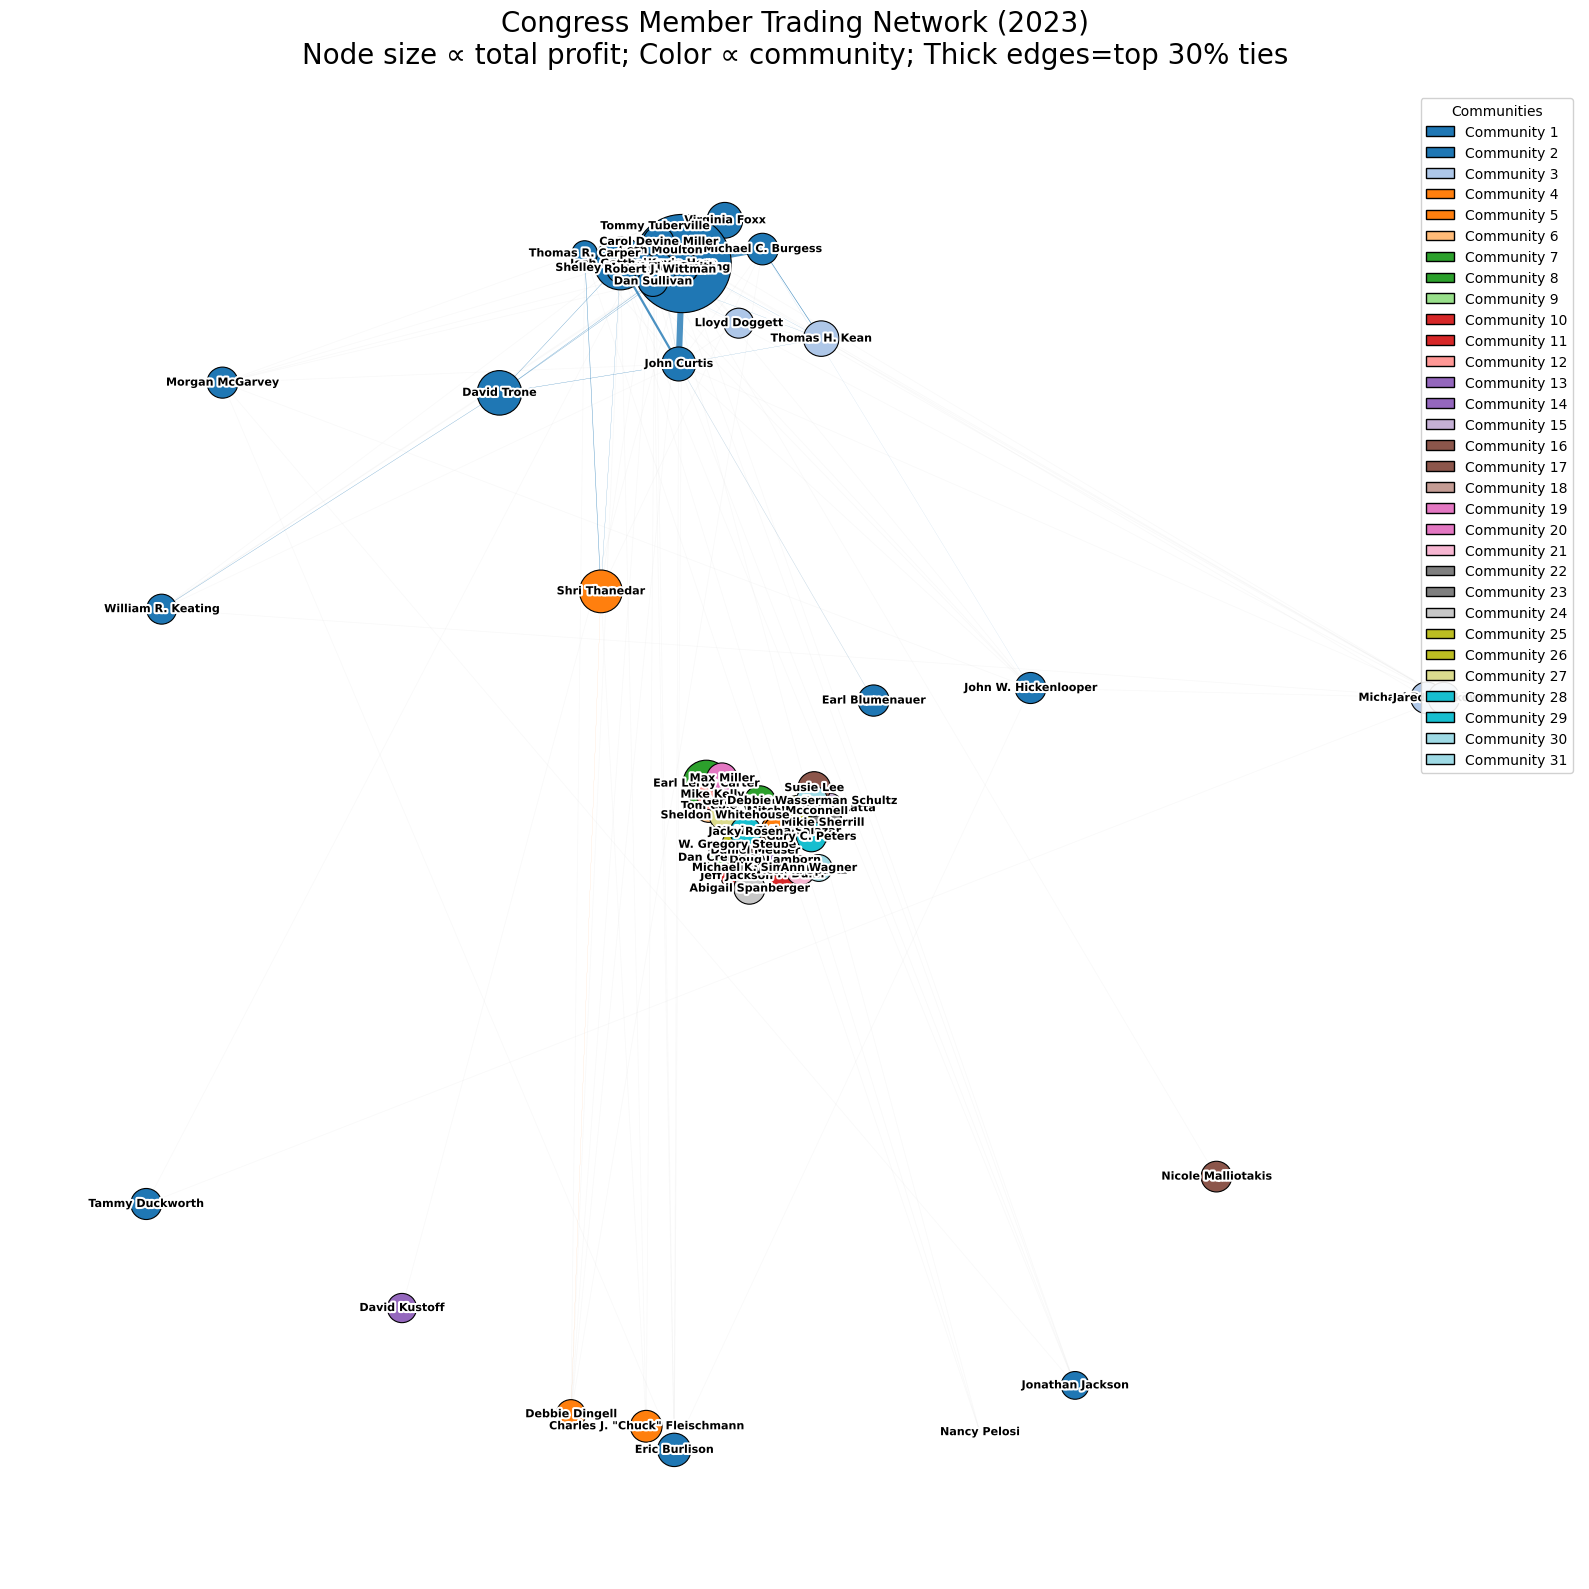

In [70]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib import patheffects
from matplotlib.patches import Patch
from networkx.algorithms import community

# --- assume you already have ---
# M           = your member–member graph
# profit_df   = DataFrame with ['member_id','profit']
# id_to_name  = dict(member_id -> full name)



# 1) detect communities
comms = list(community.greedy_modularity_communities(M, weight='weight'))
node_comm = {n: i for i, comm in enumerate(comms) for n in comm}
num_comms = len(comms)

# 2) build discrete colormap + legend handles
cmap = plt.cm.get_cmap('tab20', num_comms)
legend_handles = [
    Patch(facecolor=cmap(i), edgecolor='k', label=f"Community {i+1}")
    for i in range(num_comms)
]

# 3) compute & scale node sizes (300–2000)
profit_by_member = profit_df.groupby('member_id')['profit'].sum()
raw = np.array([profit_by_member.get(n,0) for n in M.nodes()], float)
if raw.max() > 0:
    sizes = 500 + (raw/raw.max()) * (5000 - 500)
else:
    sizes = np.full_like(raw, 500)


# 4) split edges into strong/weak for clarity
weights = np.array([d['weight'] for *_,d in M.edges(data=True)])
thr = np.quantile(weights, 0.7)
strong = [(u,v) for u,v,d in M.edges(data=True) if d['weight']>=thr]
weak   = [(u,v) for u,v,d in M.edges(data=True) if d['weight'] <thr]

# 5) layout with tighter clusters
pos = nx.spring_layout(M, k=0.01, iterations=200, seed=42)

# 6) draw
fig, ax = plt.subplots(figsize=(16,16))
ax.set_facecolor('white')

# weak edges
nx.draw_networkx_edges(M, pos,
    edgelist=weak,
    alpha=0.15,
    width=0.5,
    edge_color='lightgray',
    ax=ax
)

# strong edges colored by community mean
ec = [cmap((node_comm[u]+node_comm[v])//2) for u,v in strong]
ew = [M[u][v]['weight']/weights.max()*6 for u,v in strong]
nx.draw_networkx_edges(M, pos,
    edgelist=strong,
    width=ew,
    edge_color=ec,
    alpha=0.8,
    ax=ax
)

# nodes with black outline
nc = [cmap(node_comm[n]) for n in M.nodes()]
nx.draw_networkx_nodes(M, pos,
    node_color=nc,
    node_size=sizes,
    edgecolors='k',
    linewidths=0.8,
    ax=ax
)

# labels with white halo
for n in M.nodes():
    name = id_to_name[n]
    x,y = pos[n]
    txt = ax.text(x, y, name,
                  fontsize=8, fontweight='bold',
                  horizontalalignment='center',
                  verticalalignment='center')
    txt.set_path_effects([
        patheffects.Stroke(linewidth=3, foreground='white'),
        patheffects.Normal()
    ])

# community legend
ax.legend(handles=legend_handles,
          loc='upper right',
          title='Communities',
          frameon=True,
          framealpha=0.9)

ax.set_title(
    "Congress Member Trading Network (2023)\n"
    "Node size ∝ total profit; Color ∝ community; Thick edges=top 30% ties",
    fontsize=20,
    pad=20
)
ax.axis('off')
plt.tight_layout()
plt.show()


In [71]:
import networkx as nx
from networkx.algorithms import bipartite

# Assume `profit_df` has columns: member_id, ticker, sum_purchases, sum_sales, profit
B = nx.Graph()

# Add two node-sets
members = profit_df['member_id'].unique()
tickers = profit_df['ticker'].unique()
B.add_nodes_from(members, bipartite='members')
B.add_nodes_from(tickers, bipartite='tickers')

# Add edges weighted by profit (or by trade volume, or count)
for _, row in profit_df.iterrows():
    B.add_edge(
        row['member_id'],
        row['ticker'],
        profit=row['profit'],
        purchases=row['sum_purchases'],
        sales=row['sum_sales']
    )


